In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime, time
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import mean , concatenate
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout
from sklearn.metrics       import mean_absolute_error,r2_score
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf

pd.set_option('display.max_columns', None)

2022-10-19 01:08:09.007440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 01:08:09.207667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-19 01:08:09.207697: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-19 01:08:09.246817: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-19 01:08:10.332157: W tensorflow/stream_executor/platform/de

In [2]:
# Configuration Parameters
look_back=5000 # ~Past 6 months data to train on
n_steps_in, n_steps_out = 168, 24 # Predict next 24 values based on past 168 i.e. 7 days
nb_epochs=30

In [3]:
path_to_private_key = './ieso-dashboard-c639f1a39298.json'
credentials = service_account.Credentials.from_service_account_file(
    path_to_private_key,
    scopes=['https://www.googleapis.com/auth/cloud-platform'],
)

### Independent/ Input Variables 

In [4]:
# OLD DATA from csv file
old_ade=pd.read_csv('adequacy_202209052348.csv')
old_ade['mkt_datetime']=old_ade['mkt_datetime'].map(lambda x: datetime.strptime(x,'%m/%d/%Y %H:%M').isoformat(timespec='minutes'))

In [5]:
# CURRENT DATA from bigQuery
query_string="SELECT * FROM `ieso-dashboard.Adequacy2.Adequacy2_table` ORDER BY mkt_date, mkt_he;"
gbq_ade = pd.read_gbq(query_string, credentials=credentials)

In [6]:
hour_col = gbq_ade['mkt_he'].apply(lambda x: str(x-1)+":00")
date_col = gbq_ade['mkt_date'].apply(lambda x: str(x))

date_time=pd.to_datetime(date_col +' '+ hour_col).map(lambda x: x.isoformat(timespec='minutes'))

gbq_ade.insert(loc = 0,
          column = 'mkt_datetime',
          value = date_time)
# gbq_ade['mkt_datetime']=date_time

In [7]:
ind_var = ['mkt_datetime','int_nuc_cap','int_nuc_out','int_nuc_off','int_nuc_sch','int_gas_cap','int_gas_out','int_gas_off','int_gas_sch','int_hyd_cap','int_hyd_out','int_hyd_for','int_hyd_off','int_hyd_sch','int_win_cap','int_win_out','int_win_for','int_win_sch','int_sol_cap','int_sol_out','int_sol_for','int_sol_sch','int_bio_cap','int_bio_out','int_bio_off','int_bio_sch','int_oth_cap','int_oth_out','int_oth_off','int_oth_sch','int_tot_out','int_tot_off','int_tot_sch','imp_man_off','imp_man_sch','imp_min_off','imp_min_sch','imp_mic_off','imp_mic_sch','imp_new_off','imp_new_sch','imp_que_off','imp_que_sch','imp_tot_off','imp_tot_sch','imp_tot_est','imp_tot_cap','ont_bot_cap','ont_reg','ont_tot_sup','ont_for_dem','ont_peak_dem','ont_avg_dem','ont_emb_wind','ont_emb_sol','ont_disp_cap','ont_disp_bid','ont_disp_on','ont_disp_off','ont_hdr_bid','ont_hdr_sch','ont_hdr_cur','exp_man_bid','exp_man_sch','exp_min_bid','exp_min_sch','exp_mic_bid','exp_mic_sch','exp_new_bid','exp_new_sch','exp_que_bid','exp_que_sch','exp_tot_bid','exp_tot_sch','exp_tot_cap','grh_tot','grh_min_10n','grh_min_10s','grh_lfu','grh_add','total_req','cap_excess','energy_excess','offered_cap_excess','res_not_sch','imp_not_sch']
X_curr = gbq_ade[ind_var]
X_old = old_ade[ind_var]

In [8]:
X1=X_curr[X_curr['mkt_datetime']>max(X_old['mkt_datetime'])]  # which is '2022-09-06T23:00'
X_combined = pd.concat([X_old, X1], ignore_index=True)

In [9]:
X_combined.loc[:,ind_var] = X_combined.loc[:,ind_var].ffill()
X=X_combined.dropna() # includes all days from 1/1/20 till current date

### Target Variable (ont_ene)

In [10]:
## CURRENT DATA being fetched from bigQuery
query_string="SELECT * FROM `ieso-dashboard.RealtimeMktPrice.RealtimeMktPrice_table` ORDER BY mkt_date, mkt_he;"
gbq_rtmp = pd.read_gbq(query_string, credentials=credentials)

In [11]:
hour_col = gbq_rtmp['mkt_he'].apply(lambda x: str(x-1)+":00")
date_col = gbq_rtmp['mkt_date'].apply(lambda x: str(x))

date_time=pd.to_datetime(date_col +' '+ hour_col).map(lambda x: x.isoformat(timespec='minutes'))

gbq_rtmp.insert(loc = 0,
          column = 'mkt_datetime',
          value = date_time)

In [12]:
dep_var = ['mkt_datetime','ont_ene']
Y_curr = gbq_rtmp[dep_var]

In [13]:
## OLD DATA
old_rtmp=pd.read_csv('historical ont_ene.csv')
hour_col = old_rtmp['he'].apply(lambda x: str(x-1)+":00")
date_col = old_rtmp['mkt_date'].apply(lambda x: str(x))

date_time=pd.to_datetime(date_col +' '+ hour_col).map(lambda x: x.isoformat(timespec='minutes'))
old_rtmp.insert(loc = 0,
          column = 'mkt_datetime',
          value = date_time)

In [15]:
val_to_fillna=old_rtmp[old_rtmp['mkt_date']=='2022-05-20'].ont_ene.mean()
old_rtmp.at[20893,'ont_ene']=val_to_fillna
old_rtmp.at[20894,'ont_ene']=val_to_fillna
old_rtmp.at[20895,'ont_ene']=val_to_fillna

# old_rtmpold_rtmp['mkt_datetime']=='2022-05-20T14:00']['ont_ene']=val_to_fillna
# old_rtmp[old_rtmp['mkt_datetime']=='2022-05-20T15:00']['ont_ene']=val_to_fillna
old_rtmp=old_rtmp.dropna()

In [16]:
Y_old = old_rtmp[dep_var]
Y1=Y_curr[Y_curr['mkt_datetime']>max(Y_old['mkt_datetime'])]  # which is '2022-09-07T10:00'
Y_combined = pd.concat([Y_old, Y1], ignore_index=True)

In [17]:
Y=Y_combined.dropna() # includes all days from 1/1/20 till current date

### Merging all the columns

In [18]:
X[X['mkt_datetime'].duplicated() == True]

,mkt_datetime,int_nuc_cap,int_nuc_out,int_nuc_off,int_nuc_sch,int_gas_cap,int_gas_out,int_gas_off,int_gas_sch,int_hyd_cap,int_hyd_out,int_hyd_for,int_hyd_off,int_hyd_sch,int_win_cap,int_win_out,int_win_for,int_win_sch,int_sol_cap,int_sol_out,int_sol_for,int_sol_sch,int_bio_cap,int_bio_out,int_bio_off,int_bio_sch,int_oth_cap,int_oth_out,int_oth_off,int_oth_sch,int_tot_out,int_tot_off,int_tot_sch,imp_man_off,imp_man_sch,imp_min_off,imp_min_sch,imp_mic_off,imp_mic_sch,imp_new_off,imp_new_sch,imp_que_off,imp_que_sch,imp_tot_off,imp_tot_sch,imp_tot_est,imp_tot_cap,ont_bot_cap,ont_reg,ont_tot_sup,ont_for_dem,ont_peak_dem,ont_avg_dem,ont_emb_wind,ont_emb_sol,ont_disp_cap,ont_disp_bid,ont_disp_on,ont_disp_off,ont_hdr_bid,ont_hdr_sch,ont_hdr_cur,exp_man_bid,exp_man_sch,exp_min_bid,exp_min_sch,exp_mic_bid,exp_mic_sch,exp_new_bid,exp_new_sch,exp_que_bid,exp_que_sch,exp_tot_bid,exp_tot_sch,exp_tot_cap,grh_tot,grh_min_10n,grh_min_10s,grh_lfu,grh_add,total_req,cap_excess,energy_excess,offered_cap_excess,res_not_sch,imp_not_sch
1611,2020-03-08T03:00,13032,3030,10115,10020,9829,1379,4072,178,7824,971,4143,5777,3189,4483,1618,2865,2842,424,424,0,0,480,261,4,4,4,0,0,0,8219,22834,16233,355,94,160,0,409,0,4,0,994,9,1922,103,0,0,1449,100,26303,12989,13056,12989,196,0,481,276,-273,3,0.0,0.0,0.0,289,-211,193,-49,2332,-1450,1653,-1407,1776,-432,6243,-3549,629,1418,945,236,0,0,15033.0,11270.0,11140,10558.0,6874.0,1819
10515,2021-03-14T03:00,13081,4768,9554,8345,10833,1108,3316,216,7415,973,3061,5507,2768,4783,2373,2410,2830,478,478,0,0,480,286,4,4,0,0,7,0,10507,20798,14163,275,96,305,69,420,0,80,0,2077,9,3157,174,0,0,939,100,25523,12793,12897,12793,111,0,467,255,-248,7,0.0,0.0,0.0,444,-86,233,-79,1545,-1000,1072,-517,1090,-66,4384,-1748,500,1418,945,236,0,0,14704.0,10819.0,9870,9895.0,6883.0,2983
19251,2022-03-13T03:00,13081,4749,9247,8345,10799,2033,5078,827,7740,1076,2965,6059,3461,4843,2552,2291,2274,478,478,0,0,315,133,2,2,0,0,0,0,11499,22676,14909,142,69,165,0,280,0,0,0,1954,1549,2541,1618,0,0,2285,36,23435,14898,14974,14898,177,0,475,281,-246,35,0.0,0.0,0.0,76,-12,84,-20,1802,-1450,443,-168,1423,-214,3828,-1864,500,1418,945,236,0,0,16781.0,6654.0,5316,9106.0,8014.0,923


In [19]:
X.at[1610,'mkt_datetime']='2020-03-08T02:00'
X.at[10514,'mkt_datetime']='2021-03-14T02:00'
X.at[19250,'mkt_datetime']='2022-03-13T02:00'

In [20]:
X['mkt_datetime'] = pd.to_datetime(X.mkt_datetime)
Y['mkt_datetime'] = pd.to_datetime(Y.mkt_datetime)

merged_data = pd.merge(X,Y,how='left',on = 'mkt_datetime')
merged_data=merged_data.set_index('mkt_datetime')

In [21]:
# Loading the data
data=merged_data.copy()

# [Feature Engineering]
data.loc[data['ont_ene']<0,'ont_ene']=0 # Lower bound values to zero.... Corrects for the -ve values
mean=data['ont_ene'].mean() # Clipping outliers using z-score analysis
std=data['ont_ene'].std()

upperlimit=mean + 3 * std
data.loc[data['ont_ene']>upperlimit,'ont_ene']=upperlimit # Can try setting it None and fill forward

In [22]:
# Step 1 :: Convert to 2d array structure 
data_X=data.dropna().iloc[-look_back:,:-1].values # Keeping all the non-null rows as training data
data_y=data.dropna().iloc[-look_back:,-1].values
data_y=data_y.reshape(-1,1)

In [23]:
# Step 2 :: Normalization
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(data_X)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(data_y)

In [24]:
# Step 3 : horizontally stack columns
dataset_stacked = hstack((X_scaled, y_scaled))

In [25]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# covert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)
print ("X.shape" , X.shape) 
print ("y.shape" , y.shape)

X.shape (4810, 168, 85)
y.shape (4810, 24)


In [26]:
split = int(len(X)*0.95)
train_X , train_y = X[:split, :] , y[:split, :]
test_X , test_y = X[split:, :] , y[split:, :]

n_features = train_X.shape[2]

In [27]:
print ("train_X.shape" , train_X.shape) 
print ("train_y.shape" , train_y.shape) 
print ("test_X.shape" , test_X.shape) 
print ("test_y.shape" , test_y.shape) 
print ("n_features" , n_features)

train_X.shape (4569, 168, 85)
train_y.shape (4569, 24)
test_X.shape (241, 168, 85)
test_y.shape (241, 24)
n_features 85


In [28]:
model = Sequential()
model.add(LSTM(units = 100, activation='relu', return_sequences = True, input_shape = (n_steps_in,n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units = 100, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units = n_steps_out))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

2022-10-19 01:13:22.446331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 01:13:22.447198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-19 01:13:22.447398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-19 01:13:22.447578: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-19 01:13:22.447751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 100)          74400     
                                                                 
 dropout (Dropout)           (None, 168, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 157,224
Trainable params: 157,224
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Fit network
history = model.fit(train_X , train_y , epochs=nb_epochs, batch_size = 24, verbose=1 ,validation_data=(test_X, test_y), shuffle=False)

2022-10-19 01:13:23.590373: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 260981280 exceeds 10% of free system memory.


Epoch 1/30
191/191 [==============================] - ETA: 0s - loss: 0.0671

2022-10-19 01:14:11.548043: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13765920 exceeds 10% of free system memory.


191/191 [==============================] - 49s 240ms/step - loss: 0.0671 - val_loss: 0.0473
Epoch 2/30
191/191 [==============================] - 48s 252ms/step - loss: 0.0534 - val_loss: 0.0397
Epoch 3/30
191/191 [==============================] - 54s 284ms/step - loss: 0.0474 - val_loss: 0.0368
Epoch 4/30
191/191 [==============================] - 47s 244ms/step - loss: 0.0432 - val_loss: 0.0349
Epoch 5/30
191/191 [==============================] - 46s 243ms/step - loss: 0.0406 - val_loss: 0.0341
Epoch 6/30
191/191 [==============================] - 46s 241ms/step - loss: 0.0388 - val_loss: 0.0329
Epoch 7/30
191/191 [==============================] - 53s 278ms/step - loss: 0.0375 - val_loss: 0.0400
Epoch 8/30
191/191 [==============================] - 46s 239ms/step - loss: 0.0377 - val_loss: 0.0330
Epoch 9/30
191/191 [==============================] - 46s 240ms/step - loss: 0.0366 - val_loss: 0.0312
Epoch 10/30
191/191 [==============================] - 45s 234ms/step - loss: 0.0364

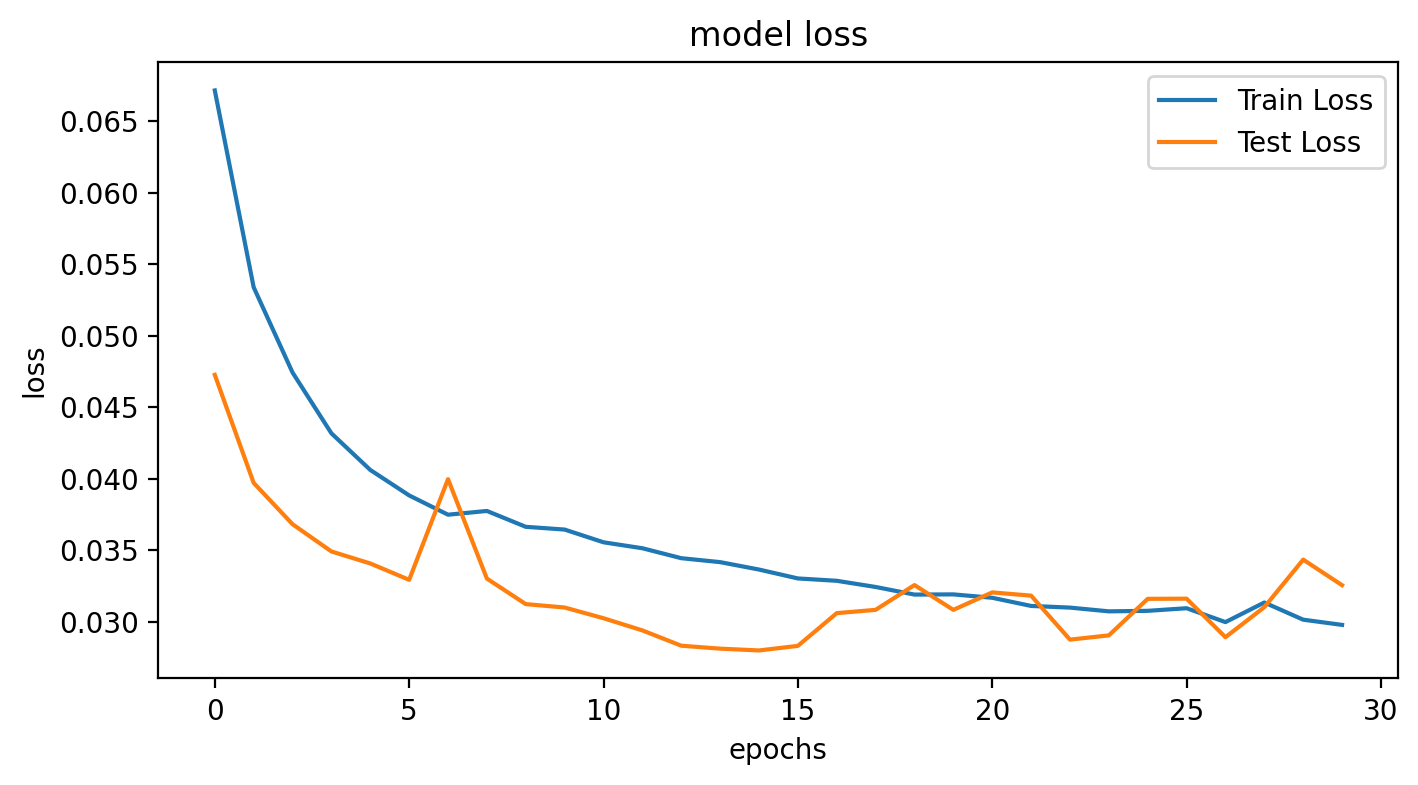

In [30]:
# Evaluation
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [31]:
# Predictions
test_sample=data_X[-n_steps_in:,:]
scaled_test_sample=scaler_X.transform(test_sample)
scaled_test_sample=scaled_test_sample.reshape(1,n_steps_in,n_features)
preds=model.predict(scaled_test_sample)
preds=scaler_y.inverse_transform(preds.reshape(-1,1))

1/1 [==============================] - 0s 399ms/step


In [32]:
## Results
# y_true=np.array([14.07,14.35,14.36,11.64,7.09,41.7,61.4,56.92,59.37,57.73,47.67,48.25,44.28,42.7,52.31,38.45,39.76,57.06,53.91,31.75,19.76,12.22,16.59,14.38]).reshape(-1,1)
# mean_absolute_error(y_true,preds)

In [33]:
idx=data.dropna().shape[0]
predictions=pd.DataFrame(preds,columns=['ont_ene'])
predictions['mkt_datetime']=data.index[idx:idx+n_steps_out]
predictions=predictions[['mkt_datetime','ont_ene']]

In [35]:
# Save Pandas dataframe to BQ
predictions.to_gbq('Predictions_24hr.LSTM', project_id='ieso-dashboard', if_exists='replace', chunksize=None)